In [15]:
import numpy as np
from numpy.linalg import eigh
from matplotlib import pyplot as plt
import matplotlib
import tfim_1d
import generate_cdf
from qcels import *
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['lines.markersize'] = 10

In [16]:
num_sites = 4
J = 1.0
g = 4.0

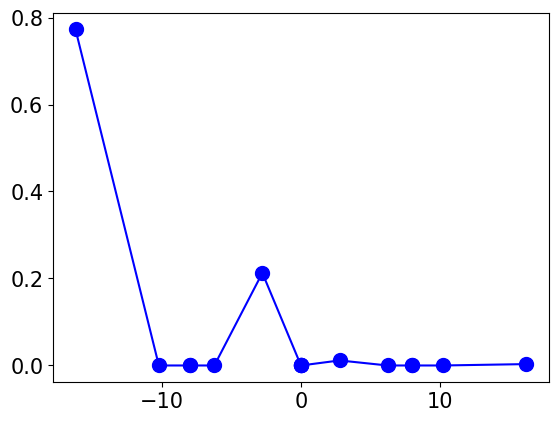

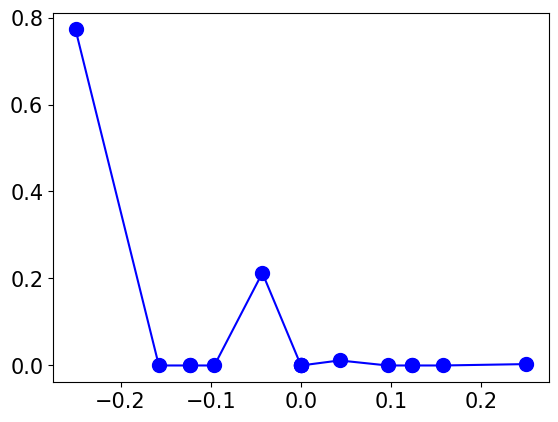

In [17]:
# move this somewhere else
def modify_spectrum(ham):
    arr_ham = ham.toarray()
    arr_ham = arr_ham.astype(np.complex128)
    n = len(arr_ham[0])
    eigenenergies, _ = ham.eigh(subset_by_index = (n-1,n-1))
    max_eigenvalue = eigenenergies[0]
    norm_ham = (1/4)*arr_ham/max_eigenvalue
    return norm_ham

# calculate the ground state with g = 1
ham0 = tfim_1d.generate_ham(num_sites, J, 1.0)
ground_state_0 = ham0.eigh(subset_by_index = (0,0))[1][:,0]


# plot original spectrum
ham = tfim_1d.generate_ham(num_sites, J, g)
eigenenergies, eigenstates = ham.eigh()
ground_state = eigenstates[:,0]
population_raw = np.abs(np.dot(eigenstates.conj().T, ground_state_0))**2
plt.plot(eigenenergies, population_raw, 'b-o')
plt.show()

old_ham = ham

# create modified spectrum
ham = modify_spectrum(old_ham)
eigenenergies, eigenstates = eigh(ham)
ground_state = eigenstates[:,0]
population = np.abs(np.dot(eigenstates.conj().T, ground_state_0))**2
plt.plot(eigenenergies, population, 'b-o')
plt.show()

In [18]:
p0_array            = np.array([0.6,0.8]) # initial overlap with the first eigenvector
N_test              = 5 # number of comparisions each trial (circuit depths)
trials              = 1
err_threshold       = 0.01
T0                  = 100

# QCELS variables
T_list_QCELS        = 10+T0/2*(np.arange(N_test)) # circuit depth for QCELS
err_QCELS           = np.zeros((len(p0_array),N_test))
cost_list_avg_QCELS = np.zeros((len(p0_array),N_test))
rate_success_QCELS  = np.zeros((len(p0_array),N_test))
max_T_QCELS         = np.zeros((len(p0_array),N_test))

# QPE variables
T_list_QPE          = 10+T0*4*(np.arange(N_test)) # circuit depth for QPE
err_QPE             = np.zeros((len(p0_array),N_test))
cost_list_avg_QPE   = np.zeros((len(p0_array),N_test))
rate_success_QPE    = np.zeros((len(p0_array),N_test))

iter = np.arange(N_test) + 1
depths = 3*np.arange(N_test) + 3

In [19]:
# set computation type to T (Theoretical Simulation), S (Quantum Simulation), or R (Quantum Hardware)
computation_type = 'T'
output_file = True


if computation_type[0].upper() == 'T':
    print("\nTHEORETICAL SIMULATION\n")
    data_name = "T_Sim"

if computation_type[0].upper() == 'S':
    print("\nQUANTUM SIMULATION\n")
    data_name = "Q_Sim"

if computation_type[0].upper() == 'R':
    print("\nQUANTUM HARDWARE\n")
    # save qiskit API token for later use
    api_token = input("Enter API Token:")
    data_name = "Q_Real"


def qcels():
    if computation_type[0].upper() == 'T':
        T = T_list_QCELS[ix]
        result = qcels_largeoverlap(T, data_pairs, Nsample, lambda_prior, computation_type = computation_type,
                                    spectrum=spectrum, population=population)
        
    if computation_type[0].upper() == 'S':
        T = iter[ix]
        result = qcels_largeoverlap(T, data_pairs, Nsample, lambda_prior, computation_type = computation_type, ham = ham, p0 = p0)

    if computation_type[0].upper() == 'R':
        from qiskit_ibm_runtime import QiskitRuntimeService as QRS
        service = QRS(channel = 'ibm_quantum', instance='rpi-rensselaer/research/faulsf', token = api_token)
        backend = service.backend('ibm_rensselaer')
        # backend = service.least_busy(simulator=False, operational=True)
        result = qcels_largeoverlap(T, data_pairs, Nsample, lambda_prior, computation_type = computation_type, ham = ham,
                                    backend = backend)
    return result

def QPE_Est():
    if computation_type[0].upper() == 'T':
        T = int(T_list_QPE[ix])
        discrete_energies = 2*np.pi*np.arange(2*T)/(2*T) - np.pi
        dist = generate_QPE_distribution(spectrum,population,2*T) #Generate QPE samples
        samp = generate_cdf.draw_with_prob(dist,N_try_QPE) # uses dist with counts to get samp
        j_min = samp.min()
        result = discrete_energies[j_min]

    if computation_type[0].upper() == 'S':
        T = depths[ix]
        result = generate_QPE_sampling_ham(ham, Nsample, T, p0 = p0)
    return result

if output_file:
    outfile = open("Output/"+str(data_name)+".txt", 'w')

for a1 in range(len(p0_array)):
    p0=p0_array[a1]
    n_success_QCELS= np.zeros(N_test)
    n_success_QPE= np.zeros(N_test)

    print("Testing p0 =", p0,"("+str(a1+1)+"/"+str(len(p0_array))+")")

    if output_file: print("Testing p0 =", p0,"("+str(a1+1)+"/"+str(len(p0_array))+")", file = outfile)

    for trial in range(trials):

        print("  Generating QCELS and QPE data", "(p0="+str(p0)+")","("+str(trial+1)+"/"+str(trials)+")")

        spectrum, population = generate_spectrum_population(eigenenergies, population_raw, [p0])

        #------------------QCELS-----------------
        Nsample = 100 # number of samples for constructing the loss function

        for ix in range(N_test):
            print("    Running QCELS", "("+str(ix+1)+"/"+str(N_test)+")")

            if output_file: print("    Running QCELS", "("+str(ix+1)+"/"+str(N_test)+")", file = outfile, flush = True)
            T = T_list_QCELS[ix]
            data_pairs = 5
            lambda_prior = spectrum[0]
            ground_energy_estimate_QCELS, cosT_depth_list_this, max_T_QCELS_this = qcels()

            print("      Estimated ground state energy =", ground_energy_estimate_QCELS)
            if output_file: print("      Estimated ground state energy =", ground_energy_estimate_QCELS.x[2], file = outfile)

            err_this_run_QCELS = np.abs(ground_energy_estimate_QCELS.x[2] - spectrum[0])
            err_QCELS[a1,ix] = err_QCELS[a1,ix]+np.abs(err_this_run_QCELS)
            cost_list_avg_QCELS[a1,ix]=cost_list_avg_QCELS[a1,ix]+cosT_depth_list_this
            max_T_QCELS[a1,ix]=max(max_T_QCELS[a1,ix],max_T_QCELS_this)

            if np.abs(err_this_run_QCELS)<err_threshold:
                n_success_QCELS[ix]+=1

        print("    Finished QCELS data\n")
        if output_file: print("    Finished QCELS data\n", file = outfile)

       # ----------------- QPE -----------------------
        N_try_QPE = int(15*np.ceil(1.0/p0)) #number of QPE samples each time

        for ix in range(N_test):
            print("    Running QPE", "("+str(ix+1)+"/"+str(N_test)+")", flush = True)
            if output_file: print("    Running QPE", "("+str(ix+1)+"/"+str(N_test)+")", file = outfile, flush=True)
            
            ground_energy_estimate_QPE = QPE_Est()

            print("      Estimated ground state energy =", ground_energy_estimate_QPE)
            if output_file: print("      Estimated ground state energy =", ground_energy_estimate_QPE, file = outfile)

            err_this_ruN_test = np.abs(ground_energy_estimate_QPE-spectrum[0])
            err_QPE[a1,ix] = err_QPE[a1,ix]+np.abs(err_this_ruN_test)

            if np.abs(err_this_ruN_test)<err_threshold:
                n_success_QPE[ix]+=1
            cost_list_avg_QPE[a1,ix] = T*N_try_QPE

        print("    Finished QPE data\n")
        if output_file: print("    Finished QPE data\n", file = outfile)

    rate_success_QCELS[a1,:] = n_success_QCELS[:]/trials
    rate_success_QPE[a1,:] = n_success_QPE[:]/trials
    err_QCELS[a1,:] = err_QCELS[a1,:]/trials
    err_QPE[a1,:] = err_QPE[a1,:]/trials
    cost_list_avg_QCELS[a1,:]=cost_list_avg_QCELS[a1,:]/trials

np.savez('Data/'+data_name+'_result_TFIM_8sites_QPE',name1=rate_success_QPE,name2=T_list_QPE,name3=cost_list_avg_QPE,name4=err_QPE)
np.savez('Data/'+data_name+'_result_TFIM_8sites_QCELS',name1=rate_success_QCELS,name2=max_T_QCELS,name3=cost_list_avg_QCELS,name4=err_QCELS)
np.savez('Data/'+data_name+'_TFIM_8sites_data',name1=spectrum,name2=population,name3=ground_energy_estimate_QCELS.x[0],
        name4=ground_energy_estimate_QCELS.x[1],name5=ground_energy_estimate_QCELS.x[2])

print("Saved data to files starting with", data_name)
if output_file: print("Saved data to files starting with", data_name, file = outfile, flush=True)
outfile.close()
if output_file: print("Saved output to file ", "Output/"+str(data_name)+".txt")



THEORETICAL SIMULATION

Testing p0 = 0.6 (1/2)
  Generating QCELS and QPE data (p0=0.6) (1/1)
    Running QCELS (1/5)
      Preprocessing
        Z_est for timestep 1 = (1+0j)
        Z_est for timestep 2 = (0.9199999999999999+0.21999999999999997j)
        Z_est for timestep 3 = (0.9199999999999999+0.32000000000000006j)
        Z_est for timestep 4 = (0.8200000000000001+0.43999999999999995j)
        Z_est for timestep 5 = (0.72+0.52j)
      Starting Iteration (1/1)
        Z_est for timestep 1 = (1+0.10000000000000009j)
        Z_est for timestep 2 = (0.8999999999999999+0.32000000000000006j)
        Z_est for timestep 3 = (0.3999999999999999+0.6000000000000001j)
        Z_est for timestep 4 = (0.52+0.76j)
        Z_est for timestep 5 = (0.1399999999999999+0.76j)
      Finished Iterations
      Estimated ground state energy =  message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.021580966080601886
       x: [ 8.650e-01  8.970e-02 -1.605e-01]
     nit: 5


In [20]:
# for a1 in range(len(p0_array)):
#     p0=p0_array[a1]
#     n_success_QCELS= np.zeros(N_test)
#     n_success_QPE= np.zeros(N_test)
#     for n_test in range(trials):
#         print("For p0=",p0,"For N_test=",n_test+1, " of ", trials)
#         spectrum, population = generate_spectrum_population(eigenenergies, 
#                 population_raw, [p0])
#         #------------------QCELS-----------------
#         Nsample=100 #number of samples for constructing the loss function
#        # ----------------- QPE -----------------------
#         N_try_QPE=int(15*np.ceil(1.0/p0)) #number of QPE samples each time
#         for ix in range(N_test):
#             T = int(T_list_QPE[ix])
#             print("START QPE", ix + 1, "of", N_test)
#             ground_energy_estimate_QPE = generate_QPE_sampling_ham(ham, Nsample, 2*T)
#             print("Estimated ground state energy =", ground_energy_estimate_QPE)
#             print("END QPE")
#             err_this_ruN_test = np.abs(ground_energy_estimate_QPE-spectrum[0])
#             err_QPE[a1,ix] = err_QPE[a1,ix]+np.abs(err_this_ruN_test)

#             if np.abs(err_this_ruN_test)<err_threshold:
#                 n_success_QPE[ix]+=1
#             cost_list_avg_QPE[a1,ix] = T*N_try_QPE
#     rate_success_QCELS[a1,:] = n_success_QCELS[:]/trials
#     rate_success_QPE[a1,:] = n_success_QPE[:]/trials
#     err_QCELS[a1,:] = err_QCELS[a1,:]/trials
#     err_QPE[a1,:] = err_QPE[a1,:]/trials
#     cost_list_avg_QCELS[a1,:]=cost_list_avg_QCELS[a1,:]/trials
# np.savez('Data/Q_Sim_result_TFIM_8sites_QPE',name1=rate_success_QPE,name2=T_list_QPE,name3=cost_list_avg_QPE,name4=err_QPE)
# np.savez('Data/Q_Sim_result_TFIM_8sites_QCELS',name1=rate_success_QCELS,name2=max_T_QCELS,name3=cost_list_avg_QCELS,name4=err_QCELS)
# np.savez('Data/Q_Sim_TFIM_8sites_data',name1=spectrum,name2=population,name3=ground_energy_estimate_QCELS.x[0],
#         name4=ground_energy_estimate_QCELS.x[1],name5=ground_energy_estimate_QCELS.x[2])